In [156]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from scipy.spatial.transform import Rotation

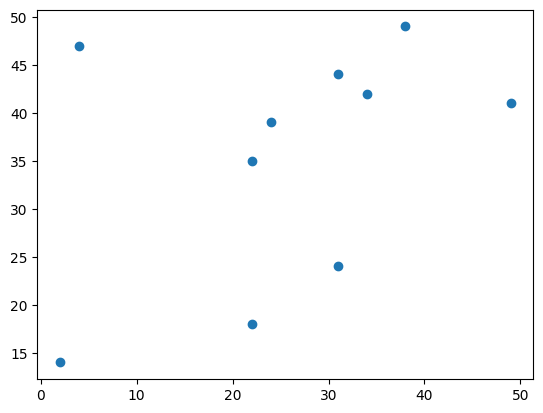

In [8]:
px = np.random.randint(0, 50, 11)
py = np.random.randint(0, 50, 11)

x, cx = px[:-1], px[-1]
y, cy = py[:-1], py[-1]

plt.scatter(x, y)
plt.show()

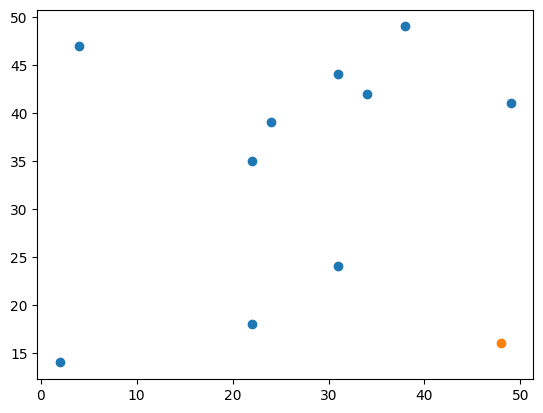

In [9]:
plt.scatter(x, y)
plt.scatter(cx, cy)
plt.show()

In [51]:
angle = 3
angle = np.radians(angle)
c, s = np.cos(angle), np.sin(angle)
R = np.array(((c, s), (-s, c)))
R

array([[ 0.99862953,  0.05233596],
       [-0.05233596,  0.99862953]])

In [52]:
points = np.stack([x, y], axis=0)
c = np.stack([cx, cy])[:, None]
print(points.shape, c.shape, (c - R @ c).shape)
rotated_points = R @ points + (c - R @ c)
rotated_points.shape

(2, 10) (2, 1) (2, 1)


(2, 10)

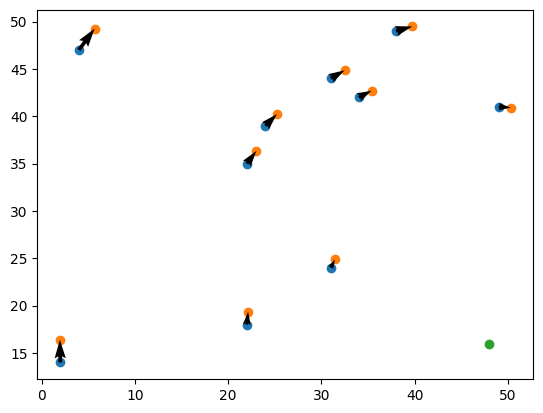

In [61]:
fig, ax = plt.subplots()
plt.scatter(points[0, :], points[1, :])
plt.scatter(rotated_points[0, :], rotated_points[1, :])
plt.scatter(cx, cy)
ax.quiver(
    points[0, :],
    points[1, :],
    rotated_points[0, :] - points[0, :],
    rotated_points[1, :] - points[1, :],
    angles='xy', scale_units='xy', scale=1
)
plt.show()

In [64]:
points.T

array([[31, 24],
       [24, 39],
       [ 2, 14],
       [22, 18],
       [31, 44],
       [ 4, 47],
       [38, 49],
       [34, 42],
       [22, 35],
       [49, 41]])

In [65]:
rotated_points.T

array([[31.44198556, 24.87874753],
       [25.23661816, 40.22454225],
       [ 1.95836949, 16.41019492],
       [22.14030401, 19.35799393],
       [32.48870468, 44.85133823],
       [ 5.68271511, 49.26029765],
       [39.74079121, 49.47813421],
       [35.37992138, 42.69707129],
       [23.03001526, 36.33469602],
       [50.30702844, 40.91340241]])

In [175]:
def generate_example(
    angle: float = 0,
    n: int = 10,
    verbose: bool = False,
    noise_mu: float = 1
):
    
    px = np.random.randint(0, 50, n + 1)
    py = np.random.randint(0, 50, n + 1)

    x, cx = px[:-1], px[-1]
    y, cy = py[:-1], py[-1]
    
    angle = np.radians(angle)
    c, s = np.cos(angle), np.sin(angle)
    R = np.array(((c, s), (-s, c)))

    points = np.stack([x, y], axis=0)
    c = np.stack([cx, cy])[:, None]
    rotated_points = R @ points + (c - R @ c)
    rotated_points += np.random.normal(
        noise_mu, 1, np.product(rotated_points.shape)
    ).reshape(rotated_points.shape)
    
    return points, rotated_points

In [164]:
def get_prerot(points, rotated_points):
    norm_points = points.T - np.mean(points.T, axis=0)
    norm_rotated = rotated_points.T - np.mean(rotated_points.T, axis=0)

    norm_points /= np.mean(np.square(norm_points))
    norm_rotated /= np.mean(np.square(norm_rotated))

    x, projs = norm_points, norm_rotated
    angle_to_prerotate = np.arctan2(
        np.sum(projs[:, 0] * x[:, 1] - projs[:, 1] * x[:, 0]),
        np.sum(projs[:, 0] * x[:, 0] + projs[:, 1] * x[:, 1])
    )

    return np.rad2deg(angle_to_prerotate)

def _get_rot_angles(gt: np.array, proj: np.array, rots_to_estim: int = 10):
    centers = []
    indexes = []
    angles = []
    for _ in range(rots_to_estim):
        idcs = np.random.choice(len(gt), 2)
        indexes.append(idcs)

        gt1, proj1 = gt[idcs[0]], proj[idcs[0]]
        gt2, proj2 = gt[idcs[1]], proj[idcs[1]]

        c = _get_center_of_rotation(gt1, proj1, gt2, proj2)
        centers.append(c)
            
    mean_c = np.array([np.median([elm[0] for elm in centers]), np.median([elm[1] for elm in centers])])

    for i in range(rots_to_estim):
        idcs = indexes[i]

        gt1, proj1 = gt[idcs[0]], proj[idcs[0]]
        gt2, proj2 = gt[idcs[1]], proj[idcs[1]]

        angle = _get_rotation(gt1, proj1, gt2, proj2, mean_c)
        angles.append(angle)

    return centers, angles      

def _get_intersect(a1, a2, b1, b2):
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

def _get_norm_of_disp(gt, proj):
    vec = (proj - gt)
    return (-vec[1], vec[0])

def _get_center_of_rotation(gt1, proj1, gt2, proj2):
    n1, n2 = _get_norm_of_disp(gt1, proj1), _get_norm_of_disp(gt2, proj2)

    first_center = (gt1 + proj1) / 2
    second_center = (gt2 + proj2) / 2

    c = _get_intersect(
        first_center, first_center + n1,
        second_center, second_center + n2,
    )

    return c

def _get_rotation(gt1, proj1, gt2, proj2, c):
    cgt1, cproj1 = gt1 - c, proj1 - c
    cgt2, cproj2 = gt2 - c, proj2 - c

    res = Rotation.align_vectors(
        a=np.array([[*cgt1, 0], [*cgt2, 0]]),
        b=np.array([[*cproj1, 0], [*cproj2, 0]])
    )
    
    return res[0]

def get_prerot_2(points, rotated_points, estimate: int = 10):
    x, projs = points, rotated_points
    _, angles = _get_rot_angles(x.T, projs.T, rots_to_estim=estimate)
    
    deg_angles = [angle.as_euler("XYZ", degrees=True)[2] for angle in angles]
    counts = np.bincount([angle + 180.0 for angle in deg_angles])
    counts = np.convolve(counts, np.ones(3), 'same')
    angle_to_prerotate = np.argmax(counts) - 180
    
    return angle_to_prerotate

100%|██████████| 360/360 [00:00<00:00, 1554.01it/s]

0.2458491325378418


(array([ 1., 10., 20., 44., 81., 82., 56., 46., 15.,  5.]),
 array([-0.89140009, -0.72218138, -0.55296267, -0.38374395, -0.21452524,
        -0.04530652,  0.12391219,  0.29313091,  0.46234962,  0.63156833,
         0.80078705]),
 <BarContainer object of 10 artists>)

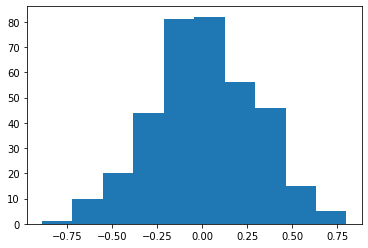

In [176]:
diffs = []
start_time = time.time()
for i in tqdm(range(-180, 180)):
    diffs.append(i - get_prerot(*generate_example(i, n=100)))
print(time.time() - start_time)

plt.hist(diffs)

  4%|▍         | 14/360 [00:00<00:02, 118.02it/s]<ipython-input-164-49222148bef4>:74: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  res = Rotation.align_vectors(
100%|██████████| 360/360 [00:01<00:00, 293.89it/s]


1.2348661422729492


(array([  1.,   2.,   4.,  39., 103., 150.,  45.,  12.,   1.,   1.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <BarContainer object of 10 artists>)

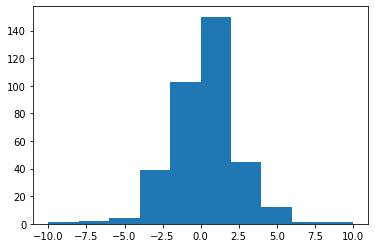

In [178]:
diffs = []
start_time = time.time()
for i in tqdm(range(-180, 180)):
    try:
        diffs.append(i - (get_prerot_2(*generate_example(i, n=100), estimate=5) + 1))
    except Exception as ex:
        print(ex)
        continue
print(time.time() - start_time)

plt.hist(diffs, range=[-10,10])